##*Authors :*


> ### *Noam Marko : 205684921*



> ### *Lidor Amitay : 203502893*




#**Project Overview:**
The Plant Pathology 2021 - FGVC8 contest main objective is to create a  
Machine learning based algorithem to classify different diseaes that can be  
found on leafs.  


## Imports & Installations

In [1]:
import os
import pandas as pd
import math
import cv2 as cv
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import numpy as np
from torch.optim import lr_scheduler
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import albumentations as A
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
%matplotlib inline

In [2]:
import gc 
gc.collect() 
torch.cuda.empty_cache()

In [3]:
!pip install torchmetrics

     |████████████████████████████████| 234 kB 8.5 MB/s 


In [4]:
import torchmetrics

In [5]:
!pip install -U git+https://github.com/albu/albumentations > /dev/null

  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-i_b2y548


In [6]:
! pip install albumentations==0.4.6

     |████████████████████████████████| 117 kB 8.7 MB/s 
     |████████████████████████████████| 948 kB 24.7 MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-py3-none-any.whl size=65173 sha256=122c404adbdddb55d8c13442ee97084c03a0c1c37972221b2bed23c1c945d6c1
  Stored in directory: /root/.cache/pip/wheels/cf/34/0f/cb2a5f93561a181a4bcc84847ad6aaceea8b5a3127469616cc
Successfully built albumentations
  Attempting uninstall: imgaug
    Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.0.3
    Uninstalling albumentations-1.0.3:
      Successfully uninstalled albumentations-1.0.3


## Downloading resized dataset

In [7]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [8]:
!pip install -q kaggle
!pip install -q kaggle-cli
!mkdir -p ~/.kaggle
!cp '/gdrive/MyDrive/Computer Vision/kaggle./kaggle.json' ~/.kaggle/ # Lidor
# !cp "/gdrive/MyDrive/CV_Final_Project/kaggle./kaggle.json" ~/.kaggle/ # Marko
!cat ~/.kaggle/kaggle.json 
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d ankursingh12/resized-plant2021 -p Dataset

     |████████████████████████████████| 74 kB 2.7 MB/s 
     |████████████████████████████████| 4.2 MB 16.2 MB/s 
     |████████████████████████████████| 49 kB 6.4 MB/s 
     |████████████████████████████████| 141 kB 68.6 MB/s 
     |████████████████████████████████| 111 kB 70.7 MB/s 
  ERROR: Failed building wheel for lxml
    Running setup.py install for lxml ... error
ERROR: Command errored out with exit status 1: /usr/bin/python3 -u -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-icokkov1/lxml_a778a0c6f6e549919575f68887a29401/setup.py'"'"'; __file__='"'"'/tmp/pip-install-icokkov1/lxml_a778a0c6f6e549919575f68887a29401/setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' install --record /tmp/pip-record-j8e89sob/install-record.txt --s

In [9]:
!unzip "/content/Dataset/resized-plant2021.zip"

Streaming output truncated to the last 5000 lines.
  inflating: img_sz_640/e00c97b2de4749ce.jpg  
  inflating: img_sz_640/e00df890cfe62736.jpg  
  inflating: img_sz_640/e00ed0bf43a87f25.jpg  
  inflating: img_sz_640/e00f759d65d52887.jpg  
  inflating: img_sz_640/e00f934d9e50ad5b.jpg  
  inflating: img_sz_640/e00fce341cb63da5.jpg  
  inflating: img_sz_640/e010c7c35ecf3d1c.jpg  
  inflating: img_sz_640/e01112939f783fec.jpg  
  inflating: img_sz_640/e01592da4d71b8be.jpg  
  inflating: img_sz_640/e0189acaf8cf80fd.jpg  
  inflating: img_sz_640/e0189e4999bdd0fa.jpg  
  inflating: img_sz_640/e01ae16d4a759cb5.jpg  
  inflating: img_sz_640/e01dc39ccb2b4ccb.jpg  
  inflating: img_sz_640/e01e42d90c66f3f3.jpg  
  inflating: img_sz_640/e01e870bec65f40f.jpg  
  inflating: img_sz_640/e01f17e0187fb80f.jpg  
  inflating: img_sz_640/e01f503cb752e6c5.jpg  
  inflating: img_sz_640/e024b69a784e9fc3.jpg  
  inflating: img_sz_640/e026b4c23c9fcfc4.jpg  
  inflating: img_sz_640/e027c790fc0a5edc.jpg  
  inflati

#=======================================================================

In [10]:
DEBUG = False

In [11]:
# GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [12]:
PATH_TO_IMAGES = '/content/img_sz_256/'

## Pre - processing


*   Count diseases 
*   One-Hot Encoding
*   Remove Duplicates
*   Label Distributaion



In [13]:
# train_df = pd.read_csv('/gdrive/MyDrive/CV_Final_Project/train.csv') # Marko
train_df = pd.read_csv('/gdrive/MyDrive/Computer Vision/Final_Project/train.csv') # Lidor

In [14]:
train_df

,image,labels
0,800113bb65efe69e.jpg,healthy
1,8002cb321f8bfcdf.jpg,scab frog_eye_leaf_spot complex
2,80070f7fb5e2ccaa.jpg,scab
3,80077517781fb94f.jpg,scab
4,800cbf0ff87721f8.jpg,complex
...,...,...
18627,fffb900a92289a33.jpg,healthy
18628,fffc488fa4c0e80c.jpg,scab
18629,fffc94e092a59086.jpg,rust
18630,fffe105cf6808292.jpg,scab frog_eye_leaf_spot


In [15]:
# Count of each disease
train_df['labels'].value_counts()

scab                               4826
healthy                            4624
frog_eye_leaf_spot                 3181
rust                               1860
complex                            1602
powdery_mildew                     1184
scab frog_eye_leaf_spot             686
scab frog_eye_leaf_spot complex     200
frog_eye_leaf_spot complex          165
rust frog_eye_leaf_spot             120
rust complex                         97
powdery_mildew complex               87
Name: labels, dtype: int64

In [16]:
from collections import defaultdict

dct = defaultdict(list)
# For each label, getting the indexes of all of the leaf images that belong to that label
for i, label in enumerate(train_df.labels):
    for category in label.split(): # if the label is comlexed
        dct[category].append(i)
 
dct = {key: np.array(val) for key, val in dct.items()}
dct

{'complex': array([    1,     4,     8, ..., 18597, 18604, 18617]),
 'frog_eye_leaf_spot': array([    1,    14,    31, ..., 18612, 18619, 18630]),
 'healthy': array([    0,     5,     7, ..., 18626, 18627, 18631]),
 'powdery_mildew': array([   20,    39,    44, ..., 18532, 18617, 18618]),
 'rust': array([    6,    21,    26, ..., 18601, 18616, 18629]),
 'scab': array([    1,     2,     3, ..., 18625, 18628, 18630])}

#### One-Hot encoding 

In [17]:
new_df = pd.DataFrame(np.zeros((train_df.shape[0], len(dct.keys())), dtype=np.int8), columns=dct.keys())

for key, val in dct.items():
    new_df.loc[val, key] = 1

new_df.head()

,healthy,scab,frog_eye_leaf_spot,complex,rust,powdery_mildew
0,1,0,0,0,0,0
1,0,1,1,1,0,0
2,0,1,0,0,0,0
3,0,1,0,0,0,0
4,0,0,0,1,0,0


In [18]:
dct.keys()

dict_keys(['healthy', 'scab', 'frog_eye_leaf_spot', 'complex', 'rust', 'powdery_mildew'])

In [19]:
classes = list(dct.keys())
NUM_OF_CLASSES = len(classes)
NUM_OF_CLASSES

6

In [20]:
# Concatenate the original data frame to the one hot encoding labels
df_all = pd.concat([train_df, new_df], axis=1)
df_all.to_csv('better_train.csv', index = False)
df_all.head()

,image,labels,healthy,scab,frog_eye_leaf_spot,complex,rust,powdery_mildew
0,800113bb65efe69e.jpg,healthy,1,0,0,0,0,0
1,8002cb321f8bfcdf.jpg,scab frog_eye_leaf_spot complex,0,1,1,1,0,0
2,80070f7fb5e2ccaa.jpg,scab,0,1,0,0,0,0
3,80077517781fb94f.jpg,scab,0,1,0,0,0,0
4,800cbf0ff87721f8.jpg,complex,0,0,0,1,0,0


#### Remove duplicates

In [21]:
# duplicates = pd.read_csv("/gdrive/MyDrive/CV_Final_Project/duplicates.csv",  names=('image1', 'image2')) #Marko
duplicates = pd.read_csv('/gdrive/MyDrive/Computer Vision/Final_Project/duplicates.csv',  names=('image1', 'image2'))
sorted_index = duplicates['image1'].sort_values().index
duplicates = duplicates.iloc[sorted_index].reset_index(drop=True)
duplicates.head()

,image1,image2
0,83e3d2369933c5d2.jpg,83e3d2329933c5f2.jpg
1,848d9f9e82d18e5e.jpg,949b6595a5b8ca3c.jpg
2,8dbeda49894d522e.jpg,afbe5641896d522a.jpg
3,8f5263c61a8cdbe2.jpg,c9d63696629107ed.jpg
4,90a5341f227ce5f9.jpg,f3dc17a2b20d48ec.jpg


In [22]:
for idx, images in duplicates.iterrows():
  # Creating masks
  mask1 = train_df['image'] == images['image1']
  mask2 = train_df['image'] == images['image2']
  # Combining two similar images labels
  tmp = train_df[mask1].iloc[0, 2:].values | train_df[mask2].iloc[0, 2:].values
  train_df.loc[mask1, train_df.columns[2:]] = tmp
  train_df = train_df.drop(train_df[mask2].index)
  # asserting that the old DF length - the duplicats length equals to the new DF length 
assert (len(new_df) - len(duplicates)) == len(train_df)


In [23]:
# y = targets, X = images id's
y = df_all.iloc[:, 2:].values
X = df_all['image'] 

###Label Distribution 


In [24]:
source = df_all['labels'].value_counts()

In [25]:
fig = go.Figure(data=[go.Pie(labels=source.index,values=source.values)])
fig.update_layout(title='Label distribution')
fig.show()

## Visualizations & Augmentations

In [26]:
def visualize_batch(path,image_ids, labels):
    plt.figure(figsize=(16, 12))
    
    for ind, (image_id, label) in enumerate(zip(image_ids, labels)):
        plt.subplot(3, 3, ind + 1)
        image = cv.imread(os.path.join(path, image_id))
        image = cv.cvtColor(image, cv.COLOR_BGR2RGB)

        plt.imshow(image)
        plt.title(f"Class: {label}", fontsize=12)
        plt.axis("off")
    plt.show()

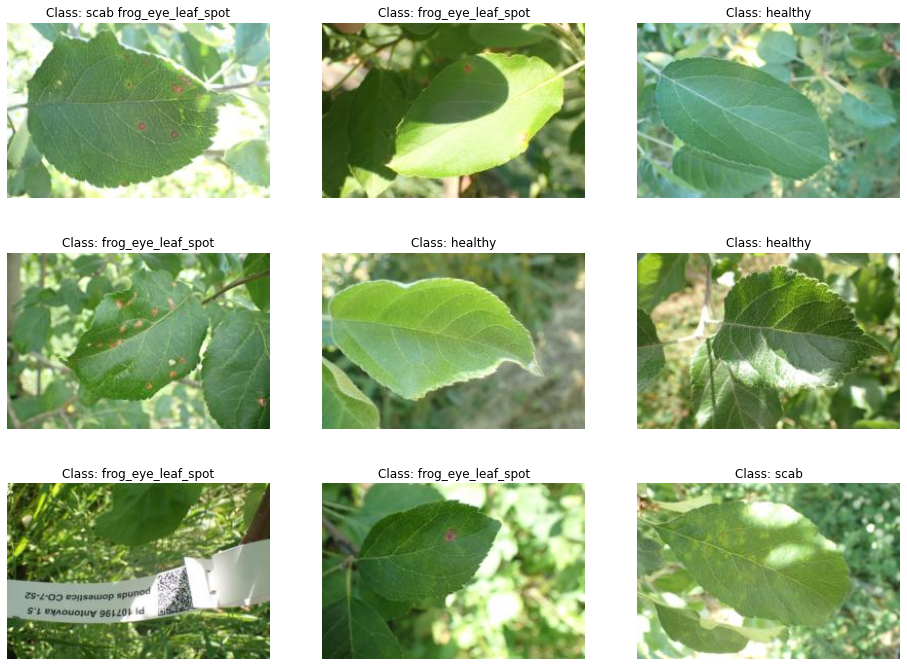

In [27]:
tmp_df = train_df.sample(9)
image_ids = tmp_df["image"].values
labels = tmp_df["labels"].values
visualize_batch(PATH_TO_IMAGES,image_ids,labels)

##Augmentations
Now we will display the chosen augmentations.  
We wanted that the augs that we have chosen will not harm the images, and just add some variation.  
The main goal of augmentation is to add diversity so our model will avoid overfitting.


In [28]:
def display_imgs(images, titles, rows, cols):
  fig = plt.figure(figsize=(18,14))
  for i in range(rows * cols):
    fig.add_subplot(rows, cols, i + 1)
    plt.imshow(images[i])
    plt.xticks([]), plt.yticks([])
    plt.title(titles[i])
  plt.show()

### Flip

In [29]:
img_id = X[np.random.randint(0, len(X))]
img = cv.imread(os.path.join(PATH_TO_IMAGES, img_id))

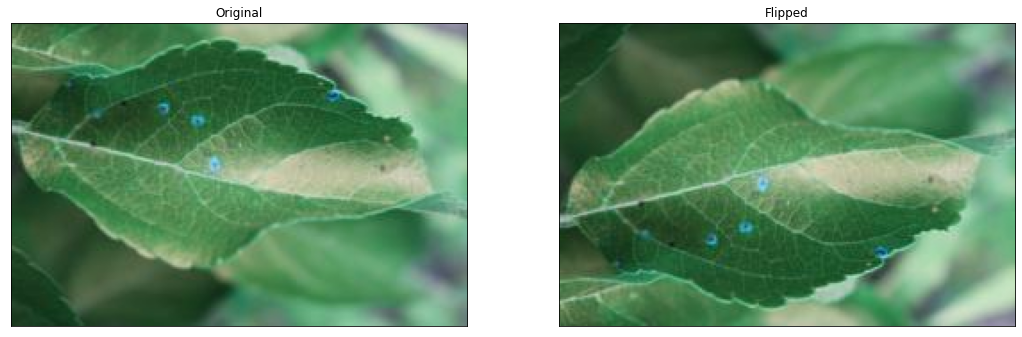

In [30]:
trans = A.Compose([A.Flip(always_apply=True),])
flipped_img = trans(image = img)['image']

display_imgs([img, flipped_img], ['Original', "Flipped"], 1, 2)

### Random Rotation
up to 90 degree

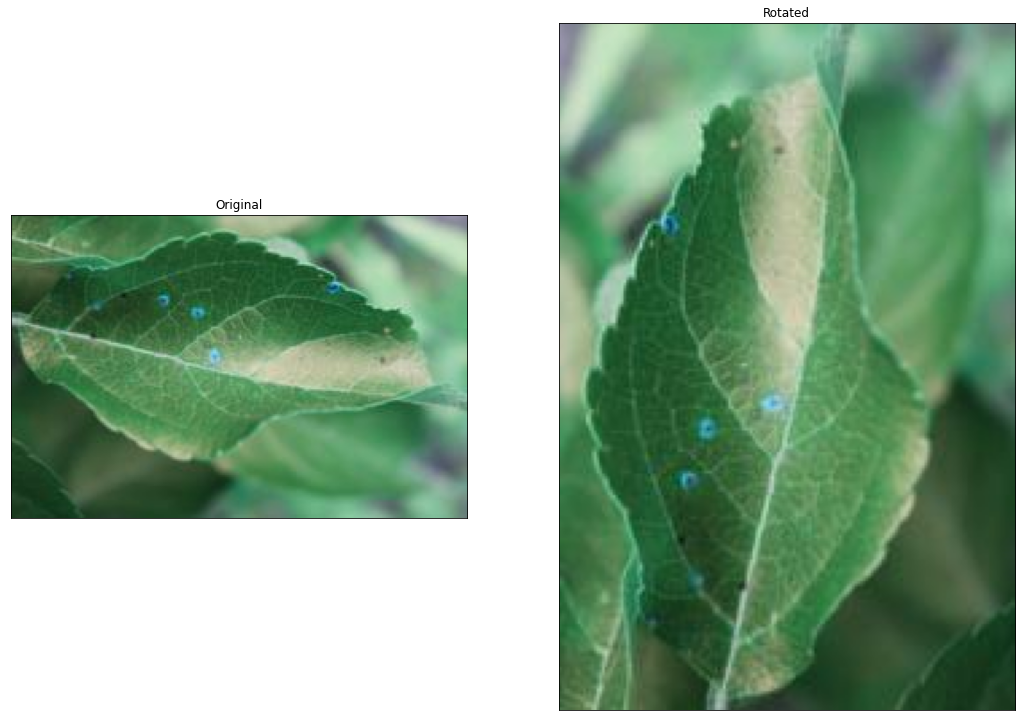

In [31]:
trans = A.Compose([A.RandomRotate90(always_apply=True),])
rotated_img = trans(image = img)['image']

display_imgs([img, rotated_img], ['Original', "Rotated"], 1, 2)

### RandomBrightnessContrast & RandomGamma

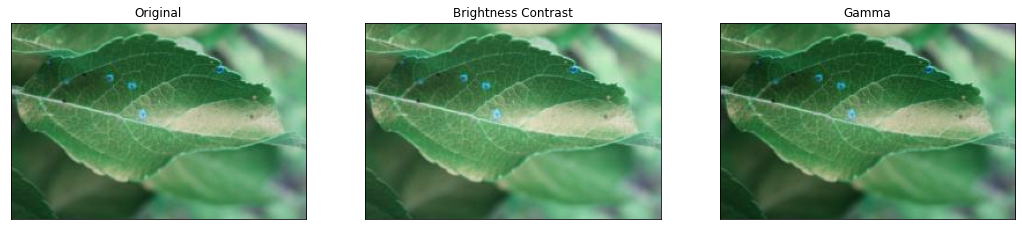

In [32]:
trans = A.Compose([A.RandomBrightnessContrast(always_apply=True),])
brighttened_img = trans(image = img)['image']

trans = A.Compose([A.RandomGamma(always_apply=True),])
gamma_img = trans(image = img)['image']

display_imgs([img, brighttened_img, gamma_img], ['Original', 'Brightness Contrast', 'Gamma'], 1, 3)

### Blur & Motion Blur

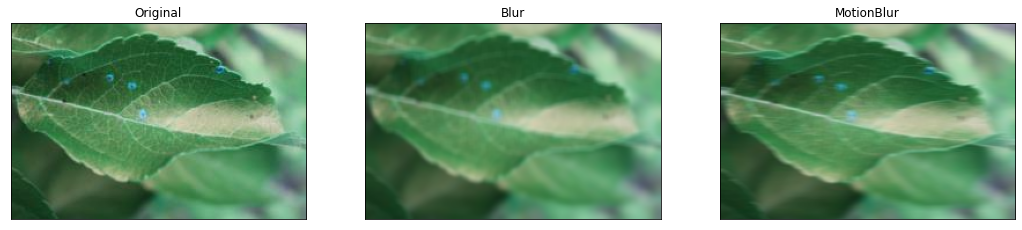

In [33]:
trans = A.Compose([A.Blur(always_apply=True),])
blurred_img = trans(image = img)['image']

trans = A.Compose([A.MotionBlur(always_apply=True),])
m_blurred_img = trans(image = img)['image']

display_imgs([img, blurred_img, m_blurred_img], ['Original', 'Blur', 'MotionBlur'], 1, 3)

In [34]:
from albumentations.pytorch import ToTensorV2

In [35]:
IMG_SIZE = 256

# Train Augmentations 
transform = A.Compose([
        A.Flip(p=0.5),
        A.RandomRotate90(p=0.5),
        A.OneOf([
                A.RandomBrightnessContrast(p=0.5),
                A.RandomGamma(p=0.5),
            ], p=0.5),
        A.OneOf([
                A.Blur(p=0.1),
                # A.GaussianBlur(p=0.1),
                A.MotionBlur(p=0.1),
        ], p=0.1),
        A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
        ),
        ToTensorV2(),
])

# Test Augmentations
test_transform = A.Compose([
        A.Normalize(
              mean=[0.485, 0.456, 0.406],
              std=[0.229, 0.224, 0.225],
        ),
        ToTensorV2(),
])

### Splitting the Data to train and test

In [36]:
TRAIN_SIZE = 0.8 # Test size 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 1 - TRAIN_SIZE, random_state=42)

In [37]:
X_train = X_train.reset_index().drop('index', axis = 1)
# y_train = y_train.reset_index().drop('index', axis = 1)

In [38]:
X_test = X_test.reset_index().drop('index', axis = 1)
# y_test = y_test.reset_index().drop('index', axis = 1)

### Define and create Datasets and Dataloaders

In [39]:
class PlantPathologyDataset(Dataset):
  def __init__(self, PATH, X, y, transform = None):
    self.PATH = PATH
    self.X = X
    self.y = y
    self.transform = transform
  
  def __len__(self):
    return len(self.y)
  
  def __getitem__(self, idx):
    img_path = self.PATH + self.X['image'][idx]
    img = cv.imread(img_path)
    img = cv.resize(img, (IMG_SIZE,IMG_SIZE))
    label = self.y[idx]
    label = torch.tensor(label)
    if self.transform :
      img = self.transform(image = img)['image']
    sample = {'image':img, 'label':label}
    return sample

In [40]:
if DEBUG:
  X_train, y_train =  X_train[:200], y_train[:200]
  X_test, y_test = X_test[:50], y_test[:50]

# dataset for the train data
train_dataset = PlantPathologyDataset(PATH_TO_IMAGES, X_train, y_train, transform) 
# dataset for the test data
test_dataset = PlantPathologyDataset(PATH_TO_IMAGES, X_test, y_test, test_transform)
print(len(train_dataset))

14905


In [41]:
BS = 32
train_dataloader = DataLoader(train_dataset, batch_size=BS, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BS, shuffle=False)

## Train, validation and helper functions

In [42]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [43]:
def save_model(model, optimizer, epoch, loss, path):
  torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, path)
  


def load_model(path, model, optimizer):
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    return epoch, loss

In [44]:
def train_epoch(train_loader, model, optimizer, criterion, metric, train_metric, train_losses):
  for i, batch in enumerate(train_loader):
    # loading the images ids and labels
    img_batch = batch['image']
    label_batch = batch['label']
    # converting to float and moving to cuda
    img_batch = img_batch.float()
    img_batch = img_batch.to(device)
    label_batch = label_batch.to(device)
    # getting predictions and activate sigmoid
    output = model(img_batch)
    output = torch.sigmoid(output)
    # calculate loss
    loss = criterion(output, label_batch.type_as(output))
    # backpropagate the loss 
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # calculate the score
    score = metric(output.detach().cpu(), label_batch.detach().cpu())
    # updating the averages
    train_metric.update(score, img_batch.size(0))
    train_losses.update(loss.item(), img_batch.size(0))
    # cleaning the GPU memory
    output.detach().cpu(), img_batch.detach().cpu() 
    del img_batch
    del label_batch
    torch.cuda.empty_cache()
  return model

In [45]:
def validation(val_loader, model, criterion, metric, valid_metric, valid_losses):
  with torch.no_grad():
    for i, batch in enumerate(val_loader):
      # loading the images ids and labels
      img_batch = batch['image']
      label_batch = batch['label']
      # converting to float and moving to cuda
      img_batch = img_batch.float()
      img_batch = img_batch.to(device)
      label_batch = label_batch.to(device)
      # getting predictions and activate sigmoid
      val_output = model(img_batch)
      val_output = torch.sigmoid(val_output)
      # calculate loss
      val_loss = criterion(val_output, label_batch.type_as(val_output))
      valid_losses.update(val_loss.item(), img_batch.size(0))
      # calculate the score
      val_metric = metric(val_output.detach().cpu(), label_batch.detach().cpu())
      valid_metric.update(val_metric, img_batch.size(0))
      # cleaning the GPU memory 
      val_output.detach().cpu(), img_batch.detach().cpu()  
      del img_batch
      del label_batch
      torch.cuda.empty_cache()
  return val_loss

In [46]:
def train(train_loader, val_loader, model, optimizer, scheduler, epochs, criterion, metric, M_PATH):
  train_metric = AverageMeter()
  train_losses = AverageMeter()
  valid_metric = AverageMeter()
  valid_losses  = AverageMeter()
  best_score = 0
  loss = 0
  # creating and saving df to display the information via graphs.
  info_df = pd.DataFrame(columns=['epoch', 'train_loss','validation_loss', 'train_score', 'validation_score', 'learning_rate'])


  model = model.to(device)
  for epoch in range(1, epochs + 1):
    train_metric.reset()
    train_losses.reset()
    valid_metric.reset()
    valid_losses.reset()

    model.train()
    model = train_epoch(train_loader, model, optimizer, criterion, metric, train_metric, train_losses)
    print(f'Epoch : {epoch}/{epochs} - Average Training   - loss :  {train_losses.avg} , score : {train_metric.avg}')
    

    model.eval()
    loss = validation(val_loader, model, criterion, metric, valid_metric, valid_losses)
    print(f'Epoch : {epoch}/{epochs} - Average Validation - loss :  {loss} , score : {valid_metric.avg}')

    loss= loss.detach().cpu()
    info_df = info_df.append({'epoch': epoch, 'train_loss': train_losses.avg,'validation_loss': loss.numpy(),
                              'train_score':train_metric.avg.numpy(), 'validation_score':valid_metric.avg.numpy(), 'learning_rate':scheduler.get_last_lr()[0]}, ignore_index=True)
    
    # saving model if the new score is higher than current best score
    if valid_metric.avg > best_score:
      best_score = valid_metric.avg
      save_model(model, optimizer, epoch, loss, M_PATH)
    
    # updating the learning rate
    scheduler.step()
  
  epoch, loss = load_model(M_PATH, model, optimizer) # load the best score model
  print(f"The best results was in epoch #{epoch} and the loss was : {loss}")
  return model, info_df

In [47]:
!mkdir models
!mkdir models/resnext50_32x4d
!mkdir models/wide_resnet50_2
!mkdir models/resnet34

## Models configurations and training

In [59]:
EPOCHS = 10

# MODEL_PATH = '/content/models/resnext50_32x4d/bestModel' #Marko
MODEL_PATH = '/gdrive/MyDrive/Computer Vision/Final_Project/models/wide_resnet50_2/best_model' #Lidor

# Resnet34
# model = models.resnet34()
# model.fc = nn.Linear(512, NUM_OF_CLASSES, bias=True)

# wide_resnet50_2
model = models.wide_resnet50_2(pretrained = True)
model.fc = nn.Linear(in_features=2048, out_features=NUM_OF_CLASSES, bias=True)

# resnext50_32x4d
# model = models.resnext50_32x4d(pretrained=False)
# model.fc = nn.Linear(in_features=2048, out_features=NUM_OF_CLASSES, bias=True)

optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
criterion = nn.BCELoss()
metric = torchmetrics.F1(NUM_OF_CLASSES, average='weighted')

In [60]:
# Full train
model, info_df = train(train_dataloader, test_dataloader, model, optimizer, scheduler, EPOCHS, criterion, metric, MODEL_PATH)
# Load Model from drive
# epoch, loss = load_model(MODEL_PATH, model, optimizer)

Epoch : 1/10 - Average Training   - loss :  0.17712682059090315 , score : 0.7803866267204285
Epoch : 1/10 - Average Validation - loss :  0.18293431401252747 , score : 0.8731724619865417
Epoch : 2/10 - Average Training   - loss :  0.12145022595140686 , score : 0.8606442213058472
Epoch : 2/10 - Average Validation - loss :  0.29140573740005493 , score : 0.8590505719184875
Epoch : 3/10 - Average Training   - loss :  0.10815520780632777 , score : 0.8765010237693787
Epoch : 3/10 - Average Validation - loss :  0.23821331560611725 , score : 0.8786198496818542
Epoch : 4/10 - Average Training   - loss :  0.09993549965844382 , score : 0.8878076672554016
Epoch : 4/10 - Average Validation - loss :  0.18399539589881897 , score : 0.8932415843009949
Epoch : 5/10 - Average Training   - loss :  0.08965334563457658 , score : 0.900466799736023
Epoch : 5/10 - Average Validation - loss :  0.133173868060112 , score : 0.8902231454849243
Epoch : 6/10 - Average Training   - loss :  0.07149002952729244 , score :

In [61]:
with torch.no_grad():
    torch.cuda.empty_cache()

In [62]:
# training results
info_df

,epoch,train_loss,validation_loss,train_score,validation_score,learning_rate
0,1,0.177127,0.18293431,0.7803866,0.87317246,0.00010
1,2,0.121450,0.29140574,0.8606442,0.8590506,0.00010
2,3,0.108155,0.23821332,0.876501,0.87861985,0.00010
3,4,0.099935,0.1839954,0.88780767,0.8932416,0.00010
4,5,0.089653,0.13317387,0.9004668,0.89022315,0.00010
5,6,0.071490,0.13279457,0.9216595,0.908675,0.00001
6,7,0.060231,0.14355761,0.9353978,0.9051101,0.00001
7,8,0.055519,0.16236888,0.9409851,0.9100102,0.00001
8,9,0.050884,0.1644146,0.9478096,0.91015357,0.00001
9,10,0.045946,0.18268849,0.9520097,0.9123353,0.00001


In [63]:
def plot_graphs(graph_df):
  plt.figure(figsize=(30, 10))
  font = {'family' : 'normal',
        'size'   : 16}
  plt.rc('font', **font)
  plt.subplot(1, 2, 1)
  plt.xlabel('Epochs', fontsize=22)
  plt.ylabel('Score', fontsize=22)
  plt.plot(graph_df['train_score'],'r')
  plt.plot(graph_df['validation_score'], '--b')
  plt.legend(['train_score' ,'validation_score'])
  plt.subplot(1, 2, 2)
  plt.xlabel('Epochs',fontsize=22)
  plt.ylabel('Loss', fontsize=22)
  plt.plot(graph_df['train_loss'], 'r')
  plt.plot(graph_df['validation_loss'], '--b')
  plt.legend(['train_loss' ,'validation loss'])
  plt.show()

### Training and validation graphs

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


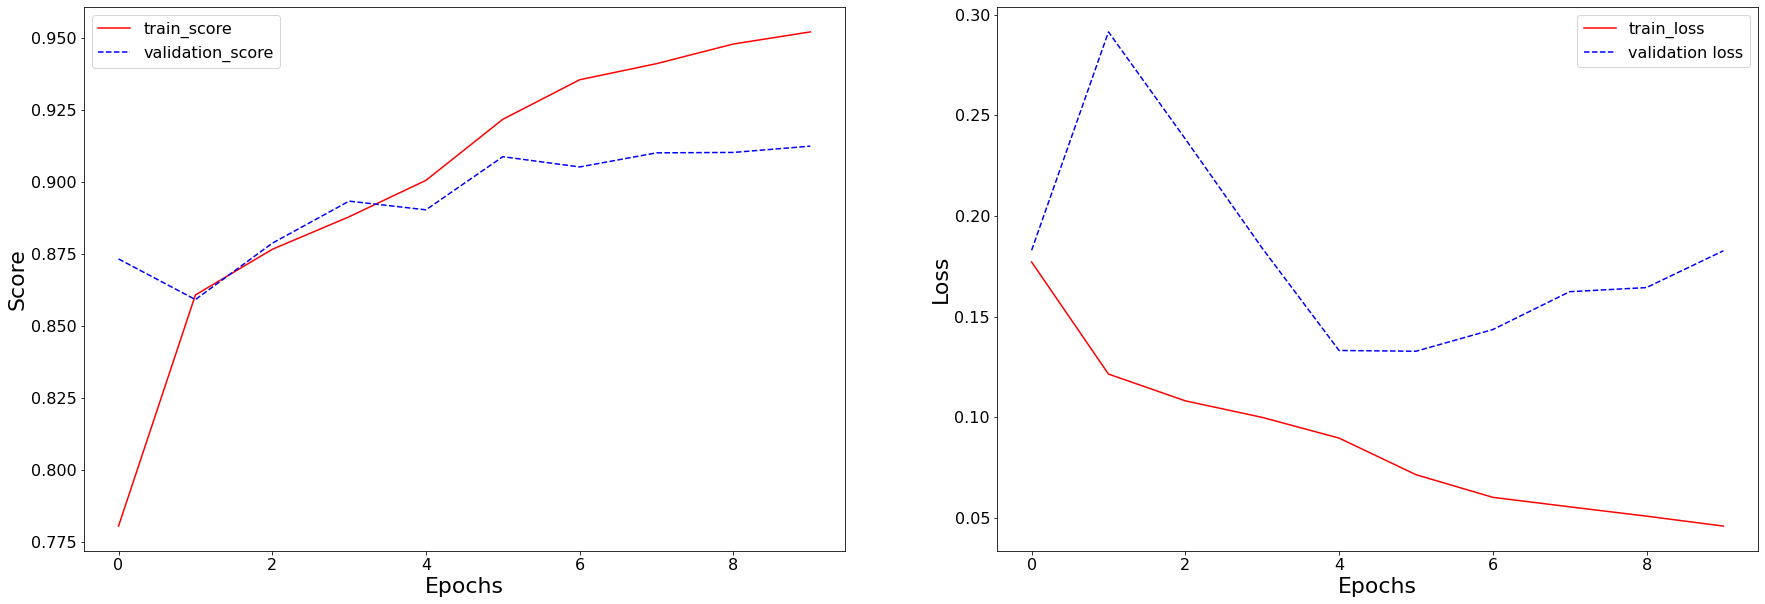

In [64]:
plot_graphs(info_df)

### Learning rate change (scheduler)

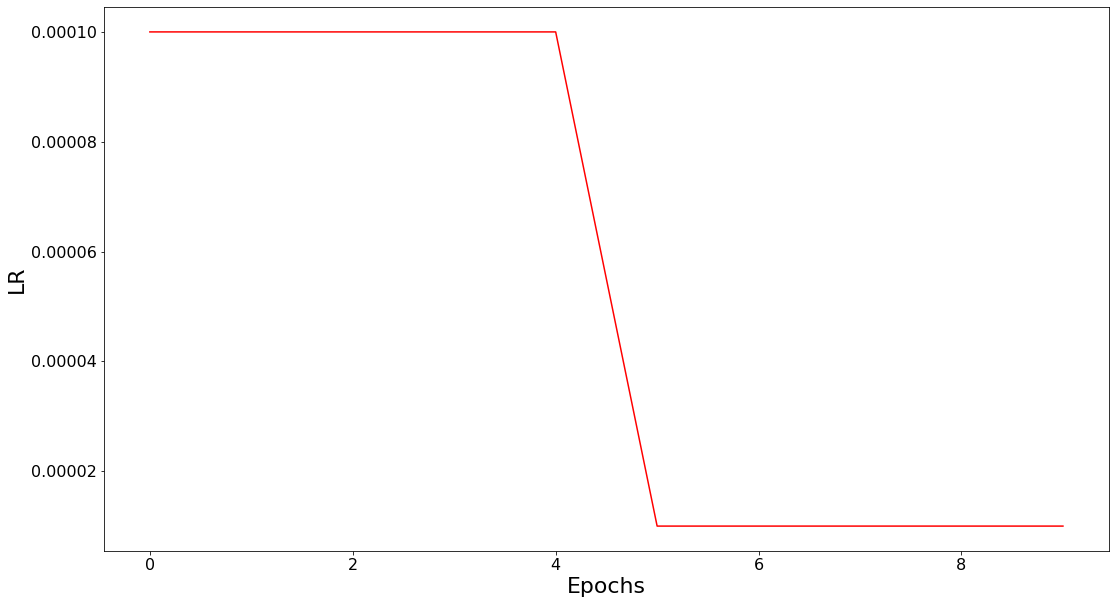

In [65]:
plt.figure(figsize=(18, 10))
plt.xlabel('Epochs', fontsize=22)
plt.ylabel('LR', fontsize=22)
plt.plot(info_df['learning_rate'],'r')
plt.show()

## Model prediction example
* This is also example of how we make the final predictions in Kaggle competition.  
Here, we are using random images from the validation set.
* The threshold  - After alot of trial and error we determined 0.3 gives as the best prediction in Kaggle submissions.

Steps : 


1.   Getting 10 random images from the validation set
2.   Preparing the images for prediction
3.   Predict the probabilities using our model
4.   For each label, if the probability for that label is higher than the threshold, we add it to the predicted labels
5.   Save the results to the dataframe





In [66]:
def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

In [67]:
def get_pred(model, img): 
    res = model(img)
    res = torch.sigmoid(res[0])
    res = to_numpy(res)
    return res

In [68]:
def prep_img(img_id, trans):
  img = cv.imread(PATH_TO_IMAGES + img_id)
  img = cv.resize(img, (IMG_SIZE,IMG_SIZE))
  img = trans(image = img)['image']
  img = img[np.newaxis,:]
  img = img.to(device)
  return img

In [69]:
# 10 random images from the test(validation) set
indexes = np.random.randint(1,len(y_test),10)
imgs_ids = X_test.iloc[indexes]['image'].values
df = pd.DataFrame(columns=['image_id', 'labels', 'predictions'])
threshold = 0.3 
for img_id in imgs_ids:
  temp = [] # will hold the diseases
  t_labels = '' # final predicted labels
  img = prep_img(img_id, test_transform)
  y = get_pred(model, img) # model predictions
  for i, label in enumerate(y):
  # if the probability from the model output is higher than the threshold, append
    if label > threshold: 
        temp.append(classes[i])
  t_labels = ' '.join(temp)
  if not t_labels:
    t_labels = classes[np.argmax(y)]

  y_labels = train_df.loc[train_df['image'] == img_id]['labels'].values[0] # true labels
  df = df.append({'image_id': img_id, 'labels': y_labels, 'predictions': t_labels}, ignore_index = True)

In [70]:
df

,image_id,labels,predictions
0,915d2f285913b56e.jpg,powdery_mildew,powdery_mildew
1,89e708976d4ae51d.jpg,frog_eye_leaf_spot,frog_eye_leaf_spot
2,c8ce8d2f1de23dc0.jpg,healthy,healthy
3,911e91388fcb8c7b.jpg,frog_eye_leaf_spot,frog_eye_leaf_spot
4,ada7c4b3c469887a.jpg,scab frog_eye_leaf_spot complex,scab frog_eye_leaf_spot complex
5,b449c0a8f9d1e3e3.jpg,scab,scab
6,adc256a5dca1a4b5.jpg,frog_eye_leaf_spot,frog_eye_leaf_spot
7,e0b8d48f9c909fd2.jpg,healthy,healthy
8,fd25c3700f51c8f2.jpg,healthy,scab
9,b512da6d657c32c4.jpg,frog_eye_leaf_spot,frog_eye_leaf_spot


## Summary 
In this project we predicted diseases for a given leaves images.  
For that purpose, we used multi - label classification and One-Hot encoding.  
We used classification models such as resnet34, wide resnet 50 and resnext50.  
we implemented various of methods and tools such as :


*   Datasets
*   Dataloaders
*   Augmentations
*   Scheduler
*   And more

We had a great time working on that project and we are feeling that our overall results are satisfying.  
We are hoping you enjoyed from our work too.



### Versions :
V1 - Model = resnet34, Pre-trained = False, Optimizer = Adam, Loss = BCE, Metric = F1, Epochs = 20, Best Score in Kaggle = 0.72

V2 - Model = resnet34, Pre-trained = False, Optimizer = Adam, Loss = BCE, Metric = F1, Added Scheduler, Epochs = 20, Best Score in Kaggle = 0.74

V3 - Model = wide_resnet50_2, Pre-trained = True, Optimizer = Adam, Loss = BCE, Metric = F1, Scheduler, Epochs = 10, Best Score in Kaggle = 0.786

V4 - Model = resnext50_32x4d, Pre-trained = True, Optimizer = Adam, Loss = BCE, Metric = F1, Scheduler, Epochs = 10, Best Score in Kaggle = 0.76





Sources :


1.   https://www.kaggle.com/nickuzmenkov/pp2021-duplicates-revealing/output
2.   https://www.kaggle.com/pegasos/plant2021-multi-label-model-training
3.   https://www.kaggle.com/praveengovi/plant-pathology-detail-eda-pytorch
4.   https://www.kaggle.com/pegasos/plant2021-multi-label-model-training/data?select=duplicates.csv
5.   https://www.kaggle.com/ateplyuk/plant-2021-starter
6.   https://www.kaggle.com/nickuzmenkov/pp2021-ultimate-preprocessing
7.   https://pytorch.org/vision/stable/models.html
8.   https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html
9.   https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.StepLR.html
10.  Functions from CV course lab sessions

